# Stan model for conversion rates

In [49]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_context('notebook')

# Operating system:
import os
import sys
import re

from tqdm import tqdm
import pystan
from scipy import stats
import random

import importlib

In [50]:
plt.rcParams.update({'font.size': 24})

# Load data

In [202]:
#Import data:
df = pd.read_csv('Input_data.csv', index_col = ['Unnamed: 0'])
df = df[df.Clicks > 0]

In [204]:
df.head(10)

,Adgroup,region_name,Conversions,Clicks
1,51764,Emilia-Romagna,0.00,13
2,35104,Venetien,0.00,12
3,71763,Venetien,0.00,16
4,51511,Emilia-Romagna,0.04,34
5,54075,Toskana,0.00,7
6,190688,Südtirol,0.00,4
7,53312,Sardinien,0.00,36
8,102506,Südtirol,0.00,25
9,36787,Kampanien,0.00,72
10,116441,Latium,0.00,2


* Adgroup is just enconding a hotel name.
* Region_name corresponds to the region where the hotel is located.
* Conversions is the number of bookings
* Clicks is the number of clicks in the hotel's website

The goal is to determine the conversion rates of each individual hotel by a hierarchical model.

# Preliminary Analysis:

In [203]:
df.groupby(['region_name'])[['Conversions']].sum()

,Conversions
region_name,
Abruzzen,0.01
Apulien,3.32
Basilikata,0.00
Emilia-Romagna,0.30
Friaul Julisch Venetien,0.00
Kalabrien,10.34
Kampanien,1.88
Latium,1.00
Ligurien,0.02


# Hierarchical Bayesian Model for conversion rates

### Model for binomial processes ($N_{Conversions} / N_{Clicks}$)

Number of conversions per click is a binomial processes, hence I use a Beta-Binomial model

\begin{align}
z \sim \text{Binomial}(N,\theta),
\end{align}

where $z$ is the number of "heads" (i.e. number of conversions) and $N$ is the total number of coin flips (i.e. number of clicks). In the hierarchical model, the bias parameter $\theta$ is obtained at a hotel level, but its prior Beta distribution has parameters ($\alpha_c$ and $\beta_c$) that are obtained at the region level. These parameters also have prior distributions, the parameters of which ($\alpha_p$ and $\beta_p$) are, in turn, obtained at an overall sampled population level. The final model can be written as: 

\begin{align}
&\theta_h \sim \text{Beta}(\alpha_r,\beta_r), \\
&\phi_r \sim \text{Beta}(\alpha_p, \beta_p), \\ 
&\phi_p \sim \text{Beta}(0.5,0.5), \\
&\kappa_r \sim \text{Pareto}(1,1.5), \\
&\kappa_p \sim \text{Pareto}(1,1.5), \\
&\alpha_r = \kappa_r \phi_r, \\
&\beta_r = \kappa_r (1 - \phi_r), \\ 
&\alpha_p = \kappa_p \phi_p, \\
&\beta_p = \kappa_p (1 - \phi_p). 
\end{align}

I have placed a weak Beta prior for the sampled population mean $\phi_p$ (note that $\phi_p = \alpha_p / (\alpha_p + \beta_p)$ is the mean of the Beta distribution) and weak Pareto priors for $\kappa_r$ and $\kappa_p$, which are inversely related to the variance of the Beta distributions. The model also assumes that hotels in the same region share the variance parameter $\kappa_r$.

In [185]:
model_flips = """
data {
  int n_hotels;
  int n_regions;
  int<lower=1> hotel2region[n_hotels];
  int<lower=0> n_flips[n_hotels];
  int<lower=0> n_heads[n_hotels];
}

parameters {
  vector<lower=0, upper=1>[n_hotels] theta;
  vector<lower=0, upper=1>[n_regions] phi_cat;
  real<lower=0, upper=1> phi_pop;
  real<lower=1> kappa_cat;
  real<lower=1> kappa_pop;
}

transformed parameters {
  vector[n_hotels] alpha;
  vector[n_hotels] beta;
  vector[n_regions] al_cat;
  vector[n_regions] be_cat;
  real al_pop;
  real be_pop;
  
  al_cat = kappa_cat * phi_cat;
  be_cat = kappa_cat * (1 - phi_cat);
  
  alpha = al_cat[hotel2region];
  beta = be_cat[hotel2region];
  
  al_pop = kappa_pop * phi_pop;
  be_pop = kappa_pop * (1 - phi_pop);
}

model {
// weak hyperpriors
  kappa_cat ~ pareto(1, 1.5);
  kappa_pop ~ pareto(1, 1.5);
  phi_pop ~ beta(0.5, 0.5);
// priors
  theta ~ beta(alpha, beta);
  phi_cat ~ beta(al_pop, be_pop);

// Likelihood
  n_heads ~ binomial(n_flips,theta);
}
"""

## 1 Prepare data to feed to Stan models

Prepare the data for the coin flip problems, i.e. $N_{conversions}$ / $N_{Clicks}$

In [180]:
# Create data frame for pooling
df_num_pool = df.copy()
# assign sample to category
x = df_num_pool['region_name'].astype('category')
df_num_pool['regions_flag'] = x.cat.codes + 1
n_region_f = len(pd.unique(df_num_pool['regions_flag']))
n_hotels_f = len(df_num_pool)

## 2 Compile models and get estimates

First set the number of iterations and chains we want to use in the MCMC algorithm:

In [186]:
# compile coin flip model
sm_flips = pystan.StanModel(model_code = model_flips, model_name = 'coin_flip_model')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL coin_flip_model_8c478c1b98e93198e20bf7336c0dc4e6 NOW.


In [187]:
n_iters = 20000
n_chains = 5

Estimate accounts per click:

In [188]:
data_dict = {'n_hotels' : n_hotels_f,
             'n_regions' : n_region_f,
             'hotel2region' : df_num_pool['regions_flag'],
             'n_flips' : np.array(df_num_pool.Clicks.astype(int)),
             'n_heads' : np.array(df_num_pool.Conversions.astype(int))}

sm_fit_apc = sm_flips.sampling(data=data_dict, iter=n_iters, chains=n_chains)
apc_out = sm_fit_apc.extract(permuted=True)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## 3 Check results

In [189]:
print(sm_fit_apc)

Inference for Stan model: coin_flip_model_8c478c1b98e93198e20bf7336c0dc4e6.
5 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=50000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]    1.8e-3  1.6e-5 2.6e-3 4.1e-8 1.5e-4 8.4e-4 2.4e-3 9.0e-3  28015    1.0
theta[2]    1.9e-3  1.4e-5 2.6e-3 7.3e-7 2.6e-4 1.0e-3 2.5e-3 9.1e-3  36556    1.0
theta[3]    1.9e-3  1.4e-5 2.6e-3 6.8e-7 2.5e-4 1.0e-3 2.5e-3 9.1e-3  35281    1.0
theta[4]    1.7e-3  1.4e-5 2.5e-3 4.1e-8 1.4e-4 7.9e-4 2.2e-3 8.4e-3  29362    1.0
theta[5]    2.0e-3  1.7e-5 2.8e-3 2.2e-7 2.3e-4 1.0e-3 2.7e-3 9.6e-3  26576    1.0
theta[6]    1.7e-3  1.4e-5 2.5e-3 1.3e-7 1.6e-4 8.2e-4 2.2e-3 8.7e-3  34036    1.0
theta[7]    1.6e-3  1.1e-5 2.2e-3 3.1e-7 1.7e-4 7.9e-4 2.0e-3 7.5e-3  42180    1.0
theta[8]    1.6e-3  1.3e-5 2.3e-3 9.9e-8 1.5e-4 7.6e-4 2.1e-3 8.0e-3  31462    1.0
theta[9]    1.5e-3  1.5e-5 2.1e-3 1.3e-7 1.5e-4 7.6e-4 

#### Probability density functions

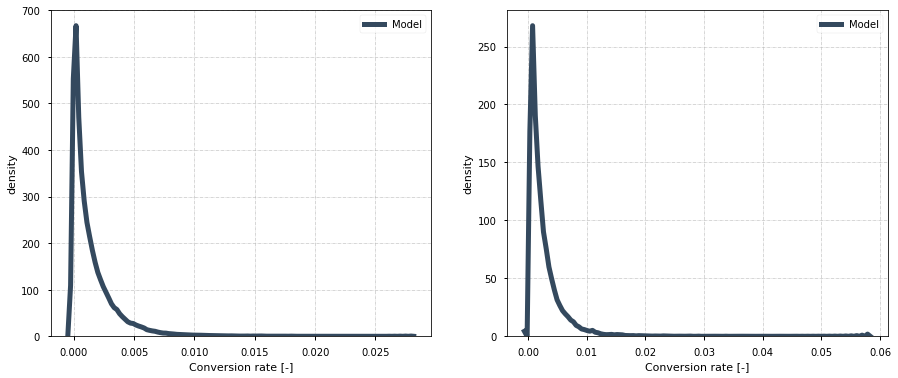

In [190]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15,6))

sns.distplot(apc_out['theta'][:, 241], rug=False, hist=False,
              kde_kws={"color": "#34495e", "lw": 5}, label = 'Model', ax=ax1)
ax1.set_xlabel('Conversion rate [-]');
ax1.grid(True, linestyle = '-.', linewidth = .5)
ax1.set_ylabel('density');

sns.distplot(apc_out['theta'][:, 0], rug=False, hist=False,
              kde_kws={"color": "#34495e", "lw": 5}, label = 'Model', ax=ax2)
ax2.set_xlabel('Conversion rate [-]');
ax2.grid(True, linestyle = '-.', linewidth = .5)
ax2.set_ylabel('density');

#### Check mixing of the Monte Carlo samples for different hotels

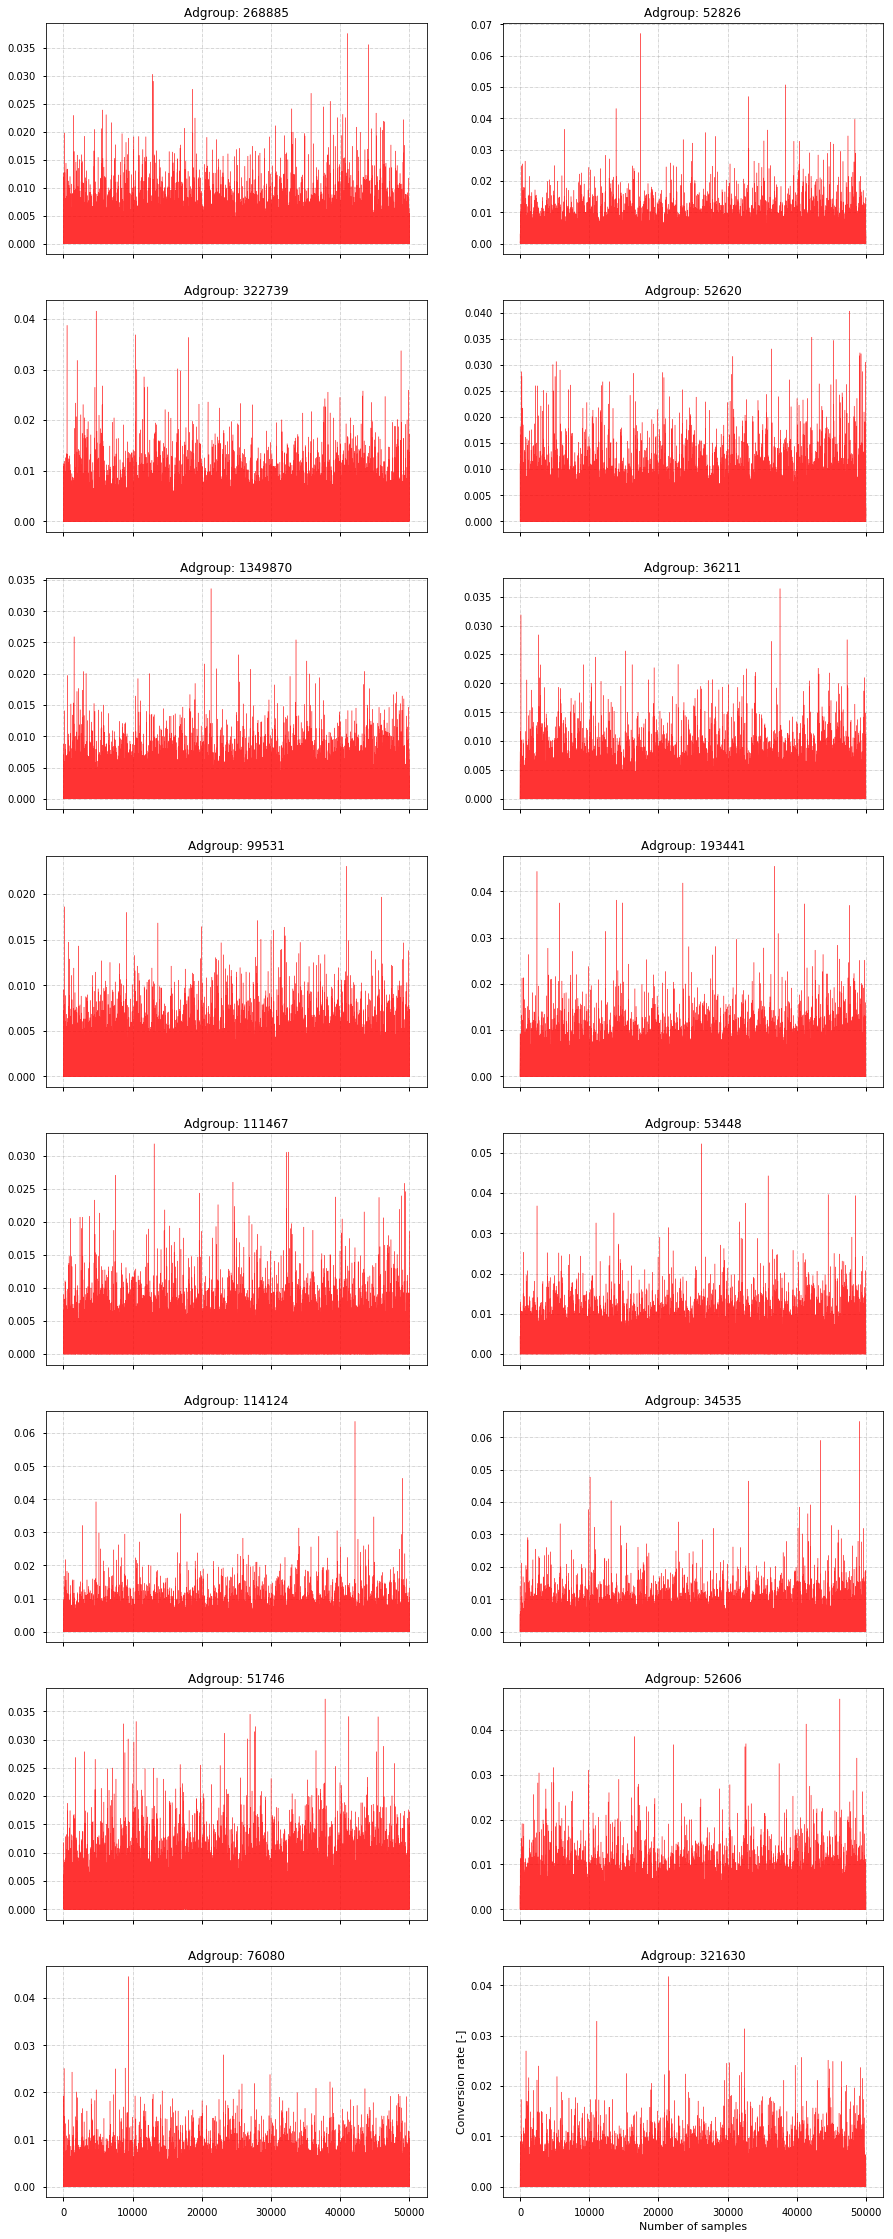

In [199]:
fig, ax = plt.subplots(8, 2, sharey=False, sharex=True, figsize=(15,40))

for i in range(0,2):
    for j in range(0,8):
        
        k = random.randint(1,241)
        ax[j,i].plot(apc_out['theta'][:,k], color = 'red', alpha = 0.8, linewidth = .4)
        ax[j,i].grid(True, linestyle = '-.', linewidth = .5)
        ax[j,i].set_title('Adgroup: ' + str(df.iloc[k]['Adgroup']));

plt.xlabel('Number of samples');
plt.ylabel('Conversion rate [-]');

#### Check joint posterior distributions

In [200]:
df_results = sm_fit_apc.to_dataframe()

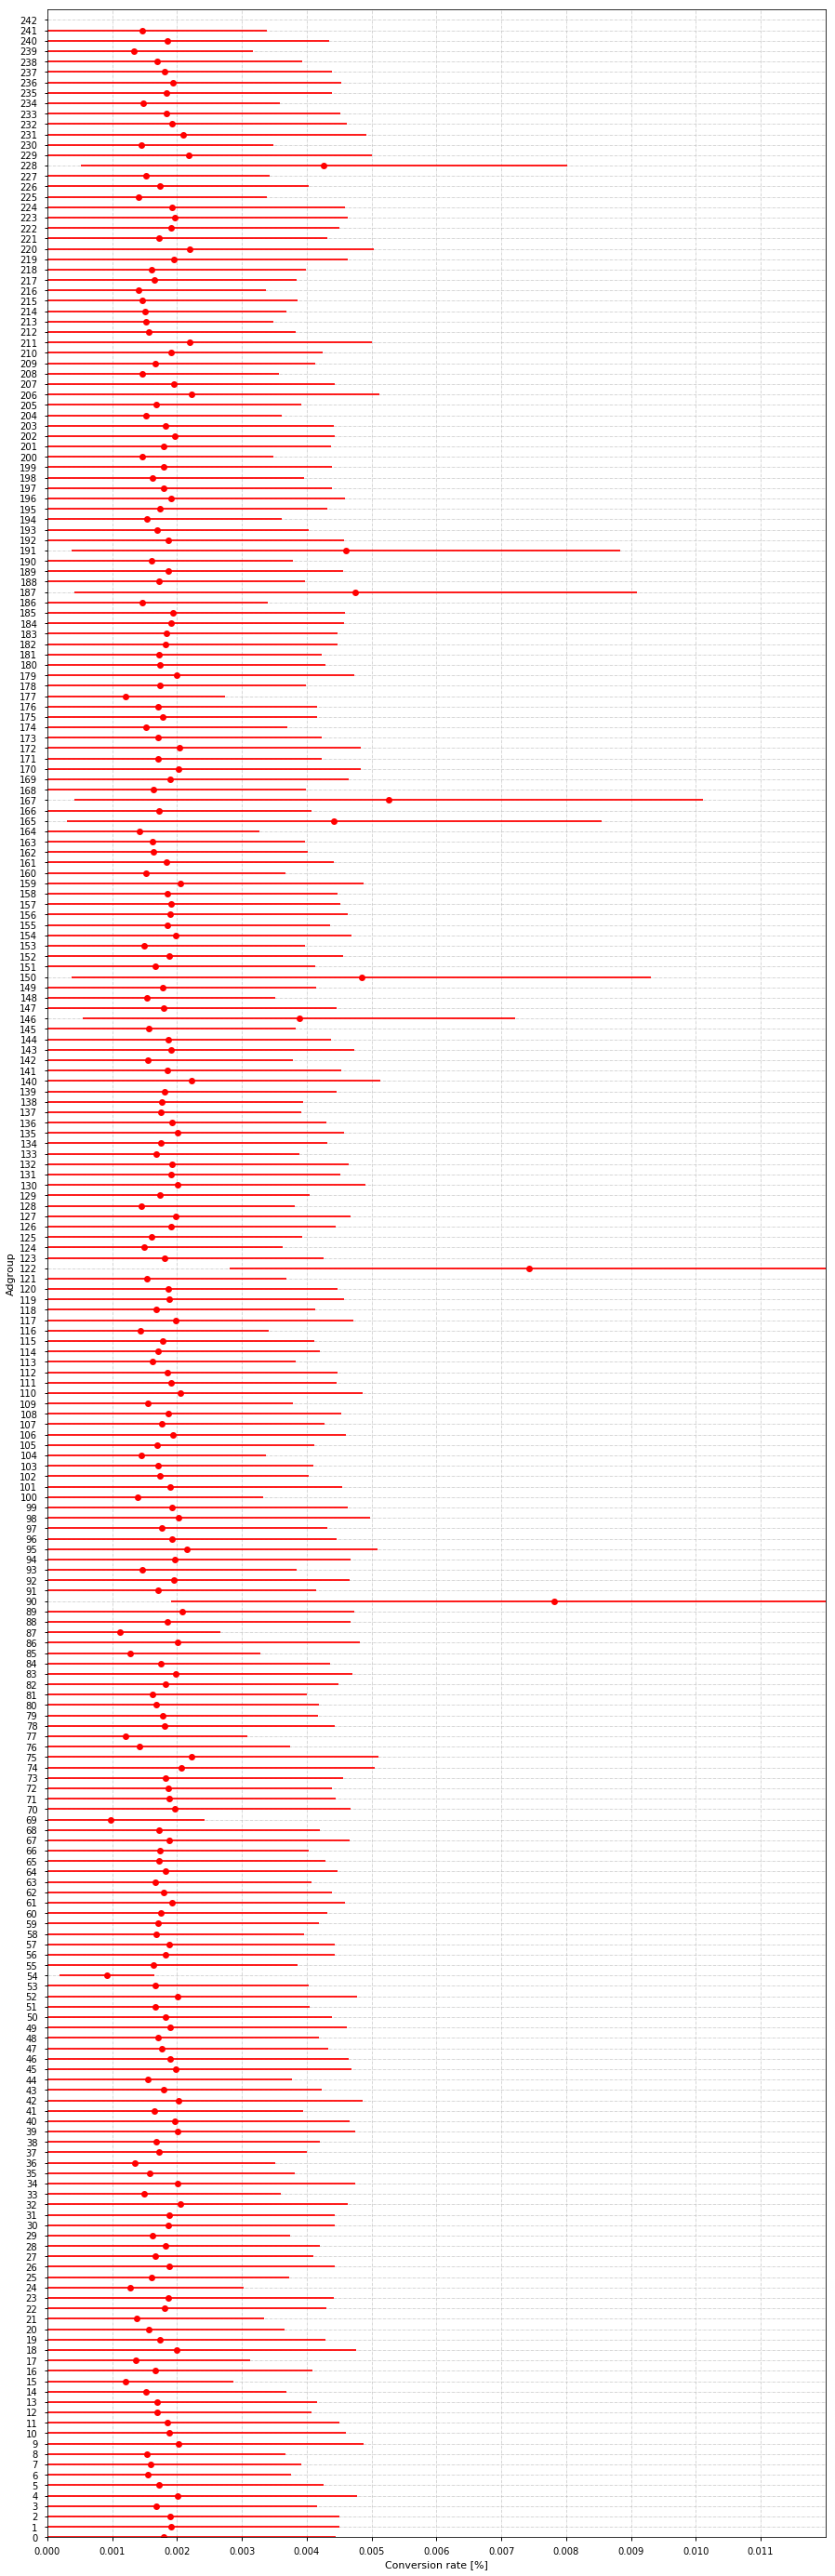

In [201]:
x = []
y = []
xerr = []

for i in list(df_results.columns[3:245]):
    x.append(df_results[i].mean())
    xerr.append(df_results[i].std())

fig, ax = plt.subplots(1,1, figsize=(15,50))

plt.errorbar(x,range(0,242,1), xerr=xerr, ls="none", c="r", marker="o")
plt.grid(True, linewidth = .5, linestyle = '-.')
plt.xticks(np.arange(0, 0.012, step=0.001))
plt.yticks(np.arange(0, 243, step=1))
plt.ylim([0,243])
plt.xlim([0,0.012])
plt.xlabel('Conversion rate [%]');
plt.ylabel('Adgroup');